In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']:
                data[var].append(np.ma.masked_where(tmask == 0,\
                            ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
   
# Add total grazing fields
aggregates['TotalGrazing'] = {}
variables.append('TotalGrazing')
for year in years:
    aggregates['TotalGrazing'][year] = sum(aggregates[var][year] for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ'])

# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
variables

['GRMESZDIAT',
 'GRMESZMRUB',
 'GRMESZPHY',
 'GRMESZPON',
 'GRMESZMICZ',
 'TotalGrazing']

In [5]:
df = pd.read_csv('https://www.cpc.ncep.noaa.gov/data/indices/soi', skiprows=87, index_col=0, delim_whitespace=True)
df = df[:-10]

In [6]:
df

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1951,1.5,0.9,-0.1,-0.3,-0.7,0.2,-1.0,-0.2,-1.1,-1.0,-0.8,-0.7
1952,-0.9,-0.6,0.5,-0.2,0.8,0.7,0.5,0.1,-0.2,0.4,0.0,-1.2
1953,0.3,-0.5,-0.2,0.2,-1.7,0.1,-0.0,-1.2,-1.2,0.1,-0.3,-0.5
1954,0.7,-0.3,0.3,0.6,0.5,0.1,0.4,1.1,0.2,0.3,0.1,1.4
1955,-0.5,1.9,0.6,-0.1,1.0,1.3,1.6,1.5,1.3,1.5,1.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016,-2.2,-2.0,-0.1,-1.2,0.4,0.6,0.4,0.7,1.2,-0.3,-0.1,0.3
2017,0.2,-0.1,0.9,-0.2,0.3,-0.4,0.8,0.5,0.6,0.9,0.9,-0.1
2018,1.1,-0.5,1.5,0.5,0.4,-0.1,0.2,-0.3,-0.9,0.4,-0.1,1.0


In [7]:
df2 = pd.read_csv('/ocean/ksuchy/MOAD/observe/NPGO.csv', index_col=0)


In [8]:
df2.index.name = "YEAR"
df2 = df2.apply(pd.to_numeric) # convert all columns of DataFrame
df2 = df2[:-1]

In [9]:
df2

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
2003,1.97,0.10,1.49,1.10,0.11,0.13,1.20,0.13,0.12,1.29,-0.88,0.45
2004,0.38,0.15,0.26,0.80,0.48,0.13,0.24,0.15,0.27,0.05,-0.23,-0.10
2005,-1.66,-1.49,-1.49,-1.69,-0.13,-1.28,-1.66,1.13,-1.57,-0.11,-1.66,-1.25
2006,0.15,-1.07,-0.14,-0.18,-0.82,-0.78,-0.20,0.27,-0.29,-1.05,-0.10,-0.65
2007,-0.24,-0.73,-0.18,0.38,0.14,1.23,1.23,1.43,0.11,1.27,0.14,0.22
2008,0.18,1.14,1.37,1.40,1.74,1.28,1.43,2.14,2.23,1.77,1.97,0.23
2009,0.14,0.11,0.30,0.24,0.18,0.27,0.18,0.14,0.10,1.15,1.05,1.06
2010,2.06,1.84,1.65,1.18,1.87,1.24,1.15,1.08,1.00,1.61,0.10,0.13
2011,0.31,0.18,1.20,0.17,1.39,1.11,1.04,1.04,1.33,1.20,0.27,0.76


In [10]:
df2.loc[2007:2020]

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
2007,-0.24,-0.73,-0.18,0.38,0.14,1.23,1.23,1.43,0.11,1.27,0.14,0.22
2008,0.18,1.14,1.37,1.40,1.74,1.28,1.43,2.14,2.23,1.77,1.97,0.23
2009,0.14,0.11,0.30,0.24,0.18,0.27,0.18,0.14,0.10,1.15,1.05,1.06
2010,2.06,1.84,1.65,1.18,1.87,1.24,1.15,1.08,1.00,1.61,0.10,0.13
2011,0.31,0.18,1.20,0.17,1.39,1.11,1.04,1.04,1.33,1.20,0.27,0.76
2012,0.12,0.12,1.12,1.93,1.63,1.94,1.86,1.73,1.36,1.87,1.40,1.20
2013,1.23,1.20,0.16,0.21,0.12,0.14,0.22,0.20,0.26,-0.68,-0.12,-1.45
2014,-0.26,-0.37,-0.22,-0.16,0.44,-0.24,-0.75,-0.18,-0.13,0.24,0.32,-0.28
2015,-0.18,-1.27,-1.40,-1.38,-0.14,-1.25,-1.47,-1.93,-2.10,-1.31,-2.25,-1.11


In [11]:
date, SOI = [], []
for year in range(2007, 2021):
    for month in range(1, 13):
        index = df.index == str(year)
        date.append(datetime(year, month, 1))
        SOI.append(float(df[month_name[month][:3].upper()][index]))
        

date = np.array(date)
SOI = np.array(SOI)
NPGO = df2.loc[2007:2020].to_numpy().flatten()

In [12]:
SOI.shape

(168,)

In [13]:
SOI

array([-0.8, -0.1,  0.2, -0.1, -0.1,  0.5, -0.3,  0.4,  0.2,  0.7,  0.9,
        1.7,  1.8,  2.6,  1.4,  0.7, -0.1,  0.6,  0.3,  1. ,  1.2,  1.3,
        1.3,  1.4,  1.1,  1.9,  0.4,  0.8, -0.1,  0.1,  0.2, -0.2,  0.3,
       -1.2, -0.6, -0.7, -1.1, -1.5, -0.7,  1.2,  0.9,  0.4,  1.8,  1.8,
        2.2,  1.7,  1.3,  2.9,  2.3,  2.7,  2.5,  1.9,  0.4,  0.2,  1. ,
        0.4,  1. ,  0.8,  1.1,  2.5,  1.1,  0.5,  0.7, -0.3,  0. , -0.4,
       -0. , -0.2,  0.2,  0.3,  0.3, -0.6, -0.1, -0.2,  1.5,  0.2,  0.8,
        1.2,  0.8,  0.2,  0.3, -0.1,  0.7,  0.1,  1.4,  0.1, -0.9,  0.8,
        0.5,  0.2, -0.2, -0.7, -0.7, -0.6, -0.9, -0.6, -0.8,  0.2, -0.7,
       -0. , -0.7, -0.6, -1.1, -1.4, -1.6, -1.7, -0.5, -0.6, -2.2, -2. ,
       -0.1, -1.2,  0.4,  0.6,  0.4,  0.7,  1.2, -0.3, -0.1,  0.3,  0.2,
       -0.1,  0.9, -0.2,  0.3, -0.4,  0.8,  0.5,  0.6,  0.9,  0.9, -0.1,
        1.1, -0.5,  1.5,  0.5,  0.4, -0.1,  0.2, -0.3, -0.9,  0.4, -0.1,
        1. , -0. , -1.4, -0.3,  0.1, -0.4, -0.5, -0

<BarContainer object of 66 artists>

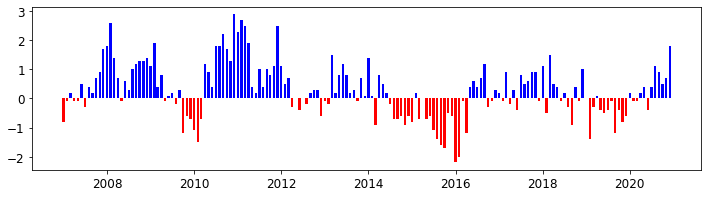

In [14]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(date[SOI>0], SOI[SOI>0], width=20, color='b')
ax.bar(date[SOI<0], SOI[SOI<0], width=20, color='r')


<BarContainer object of 82 artists>

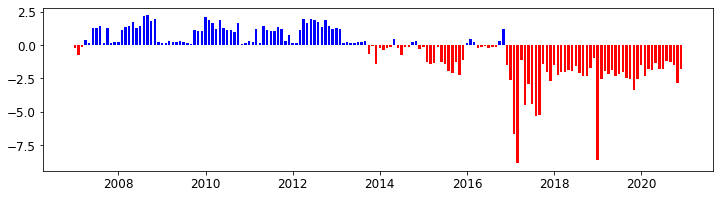

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(date[NPGO>0], NPGO[NPGO>0], width=20, color='b')
ax.bar(date[NPGO<0], NPGO[NPGO<0], width=20, color='r')



In [16]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['TotalGrazing']

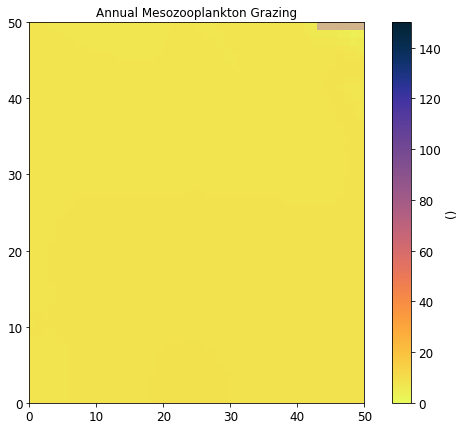

In [17]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=150
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on flag', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing']['mean']*86400))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Annual Mesozooplankton Grazing')
fig.colorbar(m0,ax=ax,label='()')




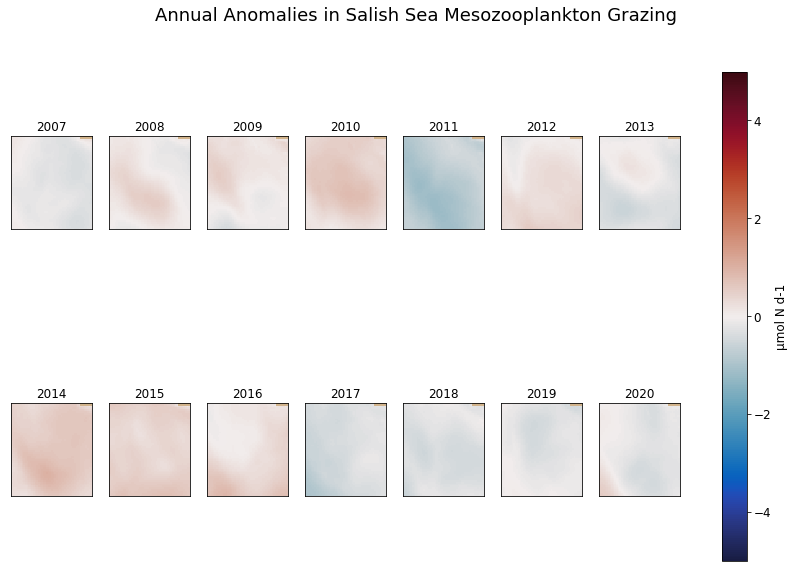

In [18]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-5
vmax=5

fig,ax=plt.subplots(2,7,figsize=(15,9))
fig.suptitle('Annual Anomalies in Salish Sea Mesozooplankton Grazing', fontsize=18)


m0=ax[0,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2007]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,0],coords='grid')
ax[0,0].set_title('2007')
ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[0,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[0,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2008]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,1],coords='grid')
ax[0,1].set_title('2008')
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[0,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2009]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,2],coords='grid')
ax[0,2].set_title('2009')
ax[0,2].yaxis.set_visible(False)
ax[0,2].xaxis.set_visible(False)
ax[0,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[0,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2010]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,3],coords='grid')
ax[0,3].set_title('2010')
ax[0,3].yaxis.set_visible(False)
ax[0,3].xaxis.set_visible(False)
ax[0,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[0,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2011]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,4],coords='grid')
ax[0,4].set_title('2011')
ax[0,4].yaxis.set_visible(False)
ax[0,4].xaxis.set_visible(False)
ax[0,4].yaxis.set_visible(False)

m0=ax[0,5].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2012]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,5],coords='grid')
ax[0,5].set_title('2012')
ax[0,5].yaxis.set_visible(False)
ax[0,5].xaxis.set_visible(False)
ax[0,5].yaxis.set_visible(False)

m0=ax[0,6].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2013]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,6],coords='grid')
ax[0,6].set_title('2013')
ax[0,6].yaxis.set_visible(False)
ax[0,6].xaxis.set_visible(False)
ax[0,6].yaxis.set_visible(False)

m0=ax[1,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2014]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,0],coords='grid')
ax[1,0].set_title('2014')
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)

m0=ax[1,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2015]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,1],coords='grid')
ax[1,1].set_title('2015')
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)

m0=ax[1,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2016]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,2],coords='grid')
ax[1,2].set_title('2016')
ax[1,2].yaxis.set_visible(False)
ax[1,2].xaxis.set_visible(False)
ax[1,2].yaxis.set_visible(False)

m0=ax[1,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2017]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,3],coords='grid')
ax[1,3].set_title('2017')
ax[1,3].yaxis.set_visible(False)
ax[1,3].xaxis.set_visible(False)
ax[1,3].yaxis.set_visible(False)

m0=ax[1,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2018]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,4],coords='grid')
ax[1,4].set_title('2018')
ax[1,4].yaxis.set_visible(False)
ax[1,4].xaxis.set_visible(False)
ax[1,4].yaxis.set_visible(False)

m0=ax[1,5].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2019]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,5],coords='grid')
ax[1,5].set_title('2019')
ax[1,5].yaxis.set_visible(False)
ax[1,5].xaxis.set_visible(False)
ax[1,5].yaxis.set_visible(False)

m0=ax[1,6].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['TotalGrazing'][2020]*86400))),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,6],coords='grid')
ax[1,6].set_title('2020')
ax[1,6].yaxis.set_visible(False)
ax[1,6].xaxis.set_visible(False)
ax[1,6].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax,label='\u03bcmol N d-1')



In [19]:
#years, months, data
monthly_array_diatoms_depthint_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['GRMESZDIAT']
# Temporary list dict
data = {}
# Permanent aggregate dict
#aggregates = {var: {} for var in variables}
#monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2013,2014,2015, 2016, 2017, 2018, 2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_diatoms_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZDIAT']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    #for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]






In [20]:
monthly_array_diatoms_depthint_slice[monthly_array_diatoms_depthint_slice == 0 ] = np.nan
monthly_array_diatoms_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_diatoms_depthint_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_diatoms_depthint_slicemean))

(14, 12)


In [21]:
monthly_array_diatoms_depthint_slicemean

array([[1.18562252e-07, 1.98509218e-07, 2.85296665e-06, 7.92253430e-05,
        8.63143054e-05, 5.64933421e-05, 4.23684634e-05, 1.88224958e-05,
        1.71187066e-05, 1.58042020e-06, 1.09645515e-06, 2.23654217e-07],
       [1.05775799e-07, 2.50742617e-07, 9.48478676e-06, 8.65034458e-05,
        1.11569549e-04, 6.51977267e-05, 5.89477789e-05, 4.27987092e-05,
        4.72876342e-05, 8.56260515e-06, 1.24444028e-06, 2.52057134e-07],
       [1.37360611e-07, 4.92431143e-07, 7.91333638e-06, 8.57047441e-05,
        9.36875825e-05, 5.16571931e-05, 5.96905363e-05, 4.30744322e-05,
        1.34615275e-05, 9.28732436e-06, 1.08447102e-06, 3.47725195e-07],
       [8.71833147e-08, 1.42229925e-07, 1.46071719e-05, 9.52268678e-05,
        1.05730265e-04, 6.91870884e-05, 5.34061038e-05, 5.49840241e-05,
        3.80044229e-05, 9.89141343e-06, 2.77897070e-06, 3.12564863e-07],
       [1.62412553e-07, 1.36576731e-07, 1.65798802e-06, 4.07574295e-05,
        1.11654725e-04, 6.08006943e-05, 3.30436341e-05, 1.58

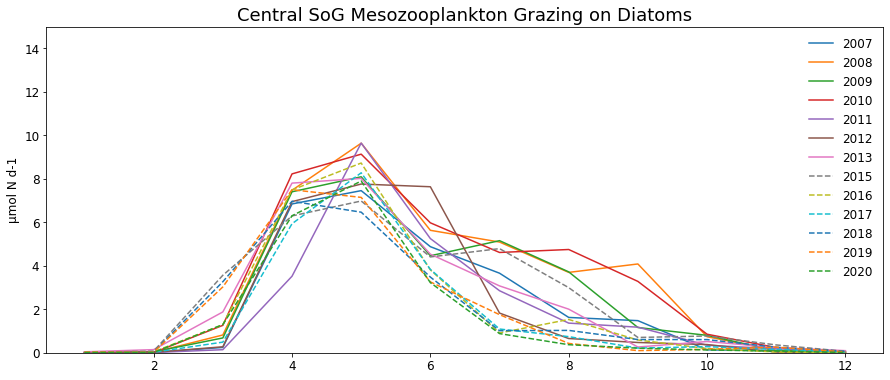

In [22]:



#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), monthly_array_diatoms_depthint_slicemean[i,:]*86400,label=2007+i)
    ax.set_title('Central SoG Mesozooplankton Grazing on Diatoms',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,125)
    ax.set_ylabel('\u03bcmol N')
   
for i in range(8,14):
    ax.plot(np.arange(1,13), monthly_array_diatoms_depthint_slicemean[i,:]*86400,linestyle='--',label=2007+i)
    ax.set_title('Central SoG Mesozooplankton Grazing on Diatoms',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,15)
    ax.set_ylabel('\u03bcmol N d-1')

In [23]:
NPGOdiatomspositive=(((monthly_array_diatoms_depthint_slicemean[0,:]+monthly_array_diatoms_depthint_slicemean[1,:]+\
        monthly_array_diatoms_depthint_slicemean[2,:]+monthly_array_diatoms_depthint_slicemean[3,:]+\
        monthly_array_diatoms_depthint_slicemean[4,:]+monthly_array_diatoms_depthint_slicemean[5,:]+\
        monthly_array_diatoms_depthint_slicemean[6,:])/7)*86400)

In [24]:
monthly_array_diatoms_depthint_slicemean[5,:]*86400

array([0.01587899, 0.02192335, 0.27699825, 6.95188712, 7.76137241,
       7.63649615, 1.82661603, 0.65632045, 0.47401192, 0.37968542,
       0.03185647, 0.0102764 ])

In [25]:
NPGOdiatomspositive

array([0.01628054, 0.03907619, 0.75880676, 6.8898702 , 8.53636512,
       5.48305301, 3.75482191, 2.54641315, 1.70420774, 0.53990845,
       0.14228057, 0.0400546 ])

In [26]:
NPGOdiatomsnegative=(((monthly_array_diatoms_depthint_slicemean[7,:]+monthly_array_diatoms_depthint_slicemean[8,:]+\
        monthly_array_diatoms_depthint_slicemean[9,:]+monthly_array_diatoms_depthint_slicemean[10,:]+\
        monthly_array_diatoms_depthint_slicemean[11,:]+monthly_array_diatoms_depthint_slicemean[12,:]+\
        monthly_array_diatoms_depthint_slicemean[13,:])/7)*86400)

In [27]:
NPGOdiatomsnegative

array([0.01881876, 0.06176423, 2.14694042, 6.85948871, 7.48580068,
       3.53733777, 1.60844638, 1.08518703, 0.37347016, 0.31476244,
       0.17169607, 0.03572367])

In [28]:
NPGOdiatomspositive.mean()

2.537594855600836

In [29]:
NPGOdiatomsnegative.mean()

1.9749530268602633

Text(0, 0.5, '$\\mu$M N d$^{-1}$')

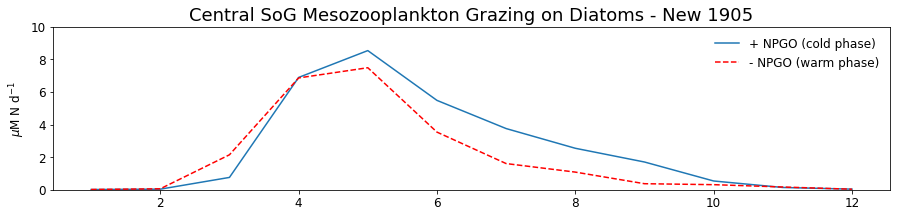

In [58]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NPGOdiatomspositive,label='+ NPGO (cold phase)')
ax.plot(np.arange(1,13), NPGOdiatomsnegative,linestyle='--',label='- NPGO (warm phase)',color='r')
ax.set_title('Central SoG Mesozooplankton Grazing on Diatoms - New 1905',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,10)
ax.set_ylabel('$\mu$M N d$^{-1}$')
   

In [31]:
RandomDiat1=(((monthly_array_diatoms_depthint_slicemean[1,:]+monthly_array_diatoms_depthint_slicemean[3,:]+\
        monthly_array_diatoms_depthint_slicemean[5,:]+monthly_array_diatoms_depthint_slicemean[7,:]+\
        monthly_array_diatoms_depthint_slicemean[9,:]+monthly_array_diatoms_depthint_slicemean[11,:]+\
        monthly_array_diatoms_depthint_slicemean[13,:])/7)*86400)

In [32]:
RandomDiat2=(((monthly_array_diatoms_depthint_slicemean[0,:]+monthly_array_diatoms_depthint_slicemean[2,:]+\
        monthly_array_diatoms_depthint_slicemean[4,:]+monthly_array_diatoms_depthint_slicemean[6,:]+\
        monthly_array_diatoms_depthint_slicemean[8,:]+monthly_array_diatoms_depthint_slicemean[10,:]+\
        monthly_array_diatoms_depthint_slicemean[12,:])/7)*86400)

Text(0, 0.5, '$\\mu$M N d$^{-1}$')

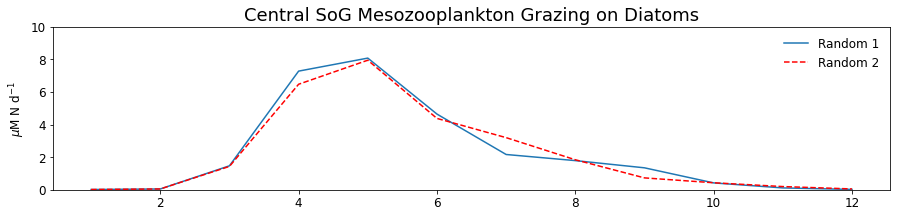

In [33]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), RandomDiat1,label='Random 1')
ax.plot(np.arange(1,13), RandomDiat2,linestyle='--',label='Random 2',color='r')
ax.set_title('Central SoG Mesozooplankton Grazing on Diatoms',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,10)
ax.set_ylabel('$\mu$M N d$^{-1}$')

In [34]:

#years, months, data
monthly_array_flag_depthint_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['GRMESZPHY']
# Temporary list dict
data = {}
# Permanent aggregate dict
#aggregates = {var: {} for var in variables}
#monthlydat = {var: {} for var in variables}
# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2013,2014,2015, 2016, 2017, 2018, 2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_flag_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['GRMESZPHY']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    # Concatenate months
    #for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)
# # Calculate 5 year mean and anomalies
# for var in variables:
#     aggregates[var][‘mean’] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#     for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var][‘mean’]





In [35]:
monthly_array_flag_depthint_slice[monthly_array_flag_depthint_slice == 0 ] = np.nan
monthly_array_flag_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_flag_depthint_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_flag_depthint_slicemean))

(14, 12)


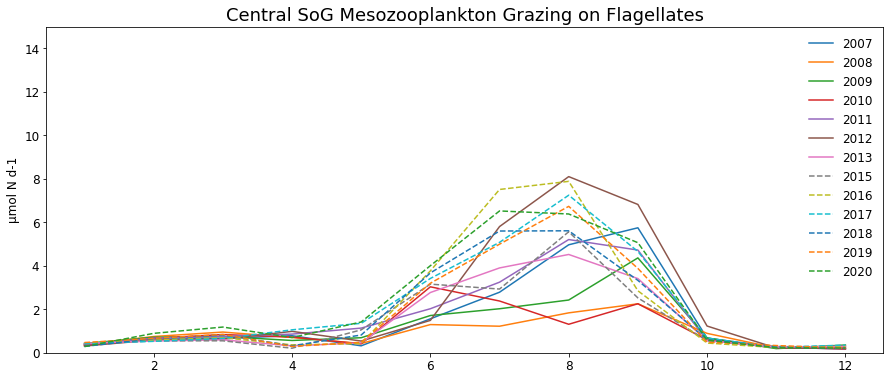

In [36]:

#plot monthly means for years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), monthly_array_flag_depthint_slicemean[i,:]*86400,label=2007+i)
    ax.set_title('Central SoG Mesozooplankton Grazing on Flagellates',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,125)
    ax.set_ylabel('\u03bcmol N')
   
for i in range(8,14):
    ax.plot(np.arange(1,13), monthly_array_flag_depthint_slicemean[i,:]*86400,linestyle='--',label=2007+i)
    ax.set_title('Central SoG Mesozooplankton Grazing on Flagellates',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,15)
    ax.set_ylabel('\u03bcmol N d-1')

In [37]:
NPGOflagpositive=(((monthly_array_flag_depthint_slicemean[0,:]+monthly_array_flag_depthint_slicemean[1,:]+\
        monthly_array_flag_depthint_slicemean[2,:]+monthly_array_flag_depthint_slicemean[3,:]+\
        monthly_array_flag_depthint_slicemean[4,:]+monthly_array_flag_depthint_slicemean[5,:]+\
        monthly_array_flag_depthint_slicemean[6,:])/7)*86400)

In [38]:
monthly_array_flag_depthint_slicemean[5,:]*86400

array([0.31091776, 0.58912334, 0.62466371, 0.98632112, 0.5401508 ,
       1.49022164, 5.80509504, 8.10277911, 6.82217016, 1.2313066 ,
       0.21977952, 0.21576261])

In [39]:
NPGOflagpositive

array([0.38175633, 0.66012533, 0.73834574, 0.70641816, 0.56963531,
       1.98549983, 3.05308293, 4.05381122, 4.22645704, 0.74321781,
       0.23573411, 0.25087242])

In [40]:
NPGOflagnegative=(((monthly_array_flag_depthint_slicemean[7,:]+monthly_array_flag_depthint_slicemean[8,:]+\
        monthly_array_flag_depthint_slicemean[9,:]+monthly_array_flag_depthint_slicemean[10,:]+\
        monthly_array_flag_depthint_slicemean[11,:]+monthly_array_flag_depthint_slicemean[12,:]+\
        monthly_array_flag_depthint_slicemean[13,:])/7)*86400)

In [41]:
NPGOflagnegative

array([0.3942073 , 0.63626981, 0.75773255, 0.46830245, 1.08595812,
       3.81328691, 5.70875945, 6.82628564, 4.03539739, 0.58498705,
       0.28134056, 0.25271547])

In [42]:
NPGOflagpositive.mean()

1.4670796862017237

In [43]:
NPGOflagnegative.mean()

2.070436890372452

Text(0, 0.5, '$\\mu$M N d$^{-1}$')

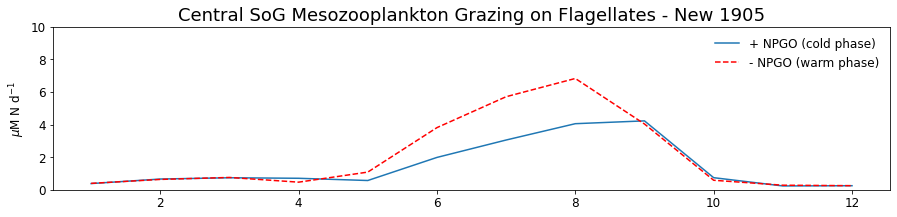

In [59]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NPGOflagpositive,label='+ NPGO (cold phase)')
ax.plot(np.arange(1,13), NPGOflagnegative,linestyle='--',label='- NPGO (warm phase)',color='r')
ax.set_title('Central SoG Mesozooplankton Grazing on Flagellates - New 1905',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,10)
ax.set_ylabel('$\mu$M N d$^{-1}$')
   

In [45]:
RandomFlag1=(((monthly_array_flag_depthint_slicemean[0,:]+monthly_array_flag_depthint_slicemean[2,:]+\
        monthly_array_flag_depthint_slicemean[4,:]+monthly_array_flag_depthint_slicemean[6,:]+\
        monthly_array_flag_depthint_slicemean[8,:]+monthly_array_flag_depthint_slicemean[10,:]+\
        monthly_array_flag_depthint_slicemean[12,:])/7)*86400)

In [46]:
RandomFlag2=(((monthly_array_flag_depthint_slicemean[1,:]+monthly_array_flag_depthint_slicemean[3,:]+\
        monthly_array_flag_depthint_slicemean[5,:]+monthly_array_flag_depthint_slicemean[7,:]+\
        monthly_array_flag_depthint_slicemean[9,:]+monthly_array_flag_depthint_slicemean[11,:]+\
        monthly_array_flag_depthint_slicemean[13,:])/7)*86400)

Text(0, 0.5, '$\\mu$M N d$^{-1}$')

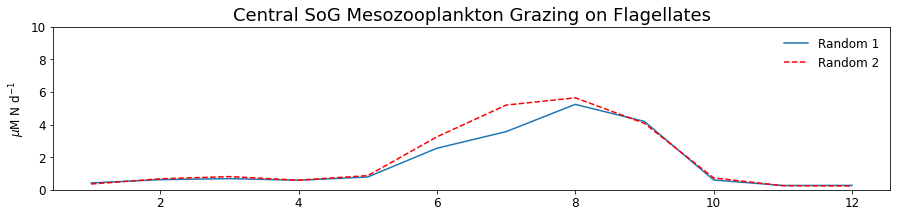

In [47]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), RandomFlag1,label='Random 1')
ax.plot(np.arange(1,13), RandomFlag2,linestyle='--',label='Random 2',color='r')
ax.set_title('Central SoG Mesozooplankton Grazing on Flagellates',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,10)
ax.set_ylabel('$\mu$M N d$^{-1}$')

In [48]:
Diatoms = monthly_array_diatoms_depthint_slicemean.flatten()

In [49]:
Flagellates = monthly_array_flag_depthint_slicemean.flatten()

In [50]:
Diatoms.shape

(168,)

In [51]:
Flagellates.shape

(168,)

In [52]:
#Diatoms

(-10.0, 10.0)

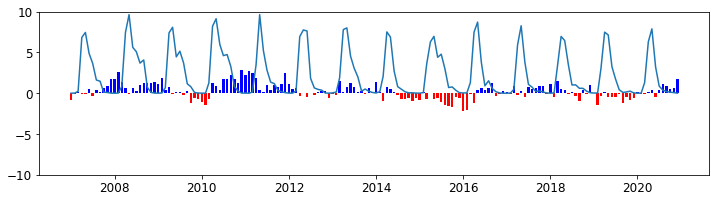

In [53]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(date[SOI>0], SOI[SOI>0], width=20, color='b')
ax.bar(date[SOI<0], SOI[SOI<0], width=20, color='r')
ax.plot(date,Diatoms*86400)
ax.set_ylim(-10,10)

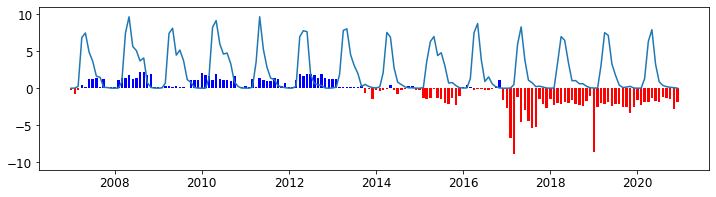

In [54]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(date[NPGO>0], NPGO[NPGO>0], width=20, color='b')
ax.bar(date[NPGO<0], NPGO[NPGO<0], width=20, color='r')
ax.set_ylim(-11,11)
ax.plot(date,Diatoms*86400)
#ax.plot(date,Flagellates*86400, color='k')

#fig, ax = plt.subplots(figsize=(12, 3))
#ax.set_ylim(0,10)
#ax.plot(date,Diatoms*86400)

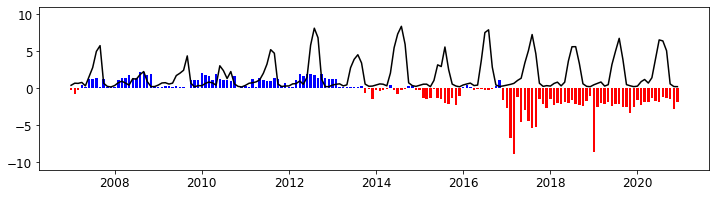

In [55]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(date[NPGO>0], NPGO[NPGO>0], width=20, color='b')
ax.bar(date[NPGO<0], NPGO[NPGO<0], width=20, color='r')
ax.set_ylim(-11,11)
#ax.plot(date,Diatoms*86400)
ax.plot(date,Flagellates*86400, color='k')

Text(0, 0.5, 'μM N d$^{-1}$')

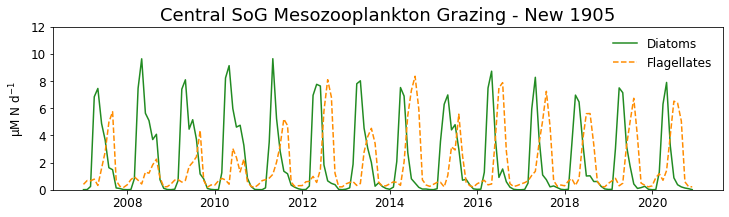

In [57]:
fig, ax = plt.subplots(figsize=(12, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]

ax.plot(date,Diatoms*86400,color='forestgreen',label='Diatoms')
ax.plot(date,Flagellates*86400, color='darkorange',linestyle='--',label='Flagellates')
ax.set_title('Central SoG Mesozooplankton Grazing - New 1905',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,12)
ax.set_ylabel('\u03bcM N d$^{-1}$')